In [1]:
#Import the libraries we will need.
# -*- coding:utf-8 -*-
import tensorflow as tf
import numpy as np
from tensorflow.contrib import rnn
from tensorflow.examples.tutorials.mnist import input_data

%matplotlib inline

In [2]:
# 设置 GPU 按需增长
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

# 首先导入数据，看一下数据的形式
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
print mnist.train.images.shape

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
(55000, 784)


### 首先设置好模型用到的各个超参数

In [3]:
#
lr = 1e-3
# 在训练和测试的时候，我们想用不同的 batch_size.所以采用占位符的方式
#batch_size = tf.placeholder(tf.int32)  # 注意类型必须为 tf.int32
# 在 1.0 版本以后请使用 ：
keep_prob = tf.placeholder(tf.float32, [])
batch_size = tf.placeholder(tf.int32, [])

# 每个时刻的输入特征是28维的，就是每个时刻输入一行，一行有 28 个像素
input_size = 28
# 时序持续长度为28，即每做一次预测，需要先输入28行
timestep_size = 28
# 每个隐含层的节点数
hidden_size = 256
# LSTM layer 的层数
layer_num = 2
# 最后输出分类类别数量，如果是回归预测的话应该是 1
class_num = 10

_X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, class_num])
keep_prob = tf.placeholder(tf.float32)

### 开始搭建 LSTM 模型

In [4]:
# 把784个点的字符信息还原成 28 * 28 的图片
# 下面几个步骤是实现 RNN / LSTM 的关键
####################################################################
# **步骤1：RNN 的输入shape = (batch_size, timestep_size, input_size) 
X = tf.reshape(_X, [-1, 28, 28])

# **步骤2：定义一层 LSTM_cell，只需要说明 hidden_size, 它会自动匹配输入的 X 的维度
#lstm_cell = rnn.BasicLSTMCell(num_units=hidden_size, forget_bias=1.0, state_is_tuple=True)
# **步骤3：添加 dropout layer, 一般只设置 output_keep_prob
#lstm_cell = rnn.DropoutWrapper(cell=lstm_cell, input_keep_prob=1.0, output_keep_prob=keep_prob)

def lstm_cell():
    #cell = rnn.LSTMCell(hidden_size, reuse=tf.get_variable_scope().reuse)
    #cell = rnn.GRUBlockCell(hidden_size)
    cell = rnn.BasicRNNCell(hidden_size)
    return rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)

# **步骤4：调用 MultiRNNCell 来实现多层 LSTM
#mlstm_cell = rnn.MultiRNNCell([lstm_cell] * layer_num, state_is_tuple=True)

mlstm_cell = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(layer_num)], state_is_tuple = True)

# **步骤5：用全零来初始化state
init_state = mlstm_cell.zero_state(batch_size, dtype=tf.float32)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


In [5]:
# **步骤6：方法一，调用 dynamic_rnn() 来让我们构建好的网络运行起来
# ** 当 time_major==False 时， outputs.shape = [batch_size, timestep_size, hidden_size] 
# ** 所以，可以取 h_state = outputs[:, -1, :] 作为最后输出
# ** state.shape = [layer_num, 2, batch_size, hidden_size], 
# ** 或者，可以取 h_state = state[-1][1] 作为最后输出
# ** 最后输出维度是 [batch_size, hidden_size]
outputs, state = tf.nn.dynamic_rnn(mlstm_cell, inputs=X, initial_state=init_state, time_major=False)
h_state = outputs[:, -1, :]  # 或者 h_state = state[-1][1]

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
# *************** 为了更好的理解 LSTM 工作原理，我们把上面 步骤6 中的函数自己来实现 ***************
# 通过查看文档你会发现， RNNCell 都提供了一个 __call__()函数（见最后附），我们可以用它来展开实现LSTM按时间步迭代。
# **步骤6：方法二，按时间步展开计算
'''
outputs = list()
state = init_state
with tf.variable_scope('RNN'):
    for timestep in range(timestep_size):
        if timestep > 0:
            tf.get_variable_scope().reuse_variables()
        # 这里的state保存了每一层 LSTM 的状态
        print(state)
        (cell_output, state) = mlstm_cell(X[:, timestep, :], state)
        outputs.append(cell_output)
h_state = outputs[-1]
''';

### 设置 loss function 和 优化器

In [7]:
# 上面 LSTM 部分的输出会是一个 [hidden_size] 的tensor，我们要分类的话，还需要接一个 softmax 层
# 首先定义 softmax 的连接权重矩阵和偏置
# out_W = tf.placeholder(tf.float32, [hidden_size, class_num], name='out_Weights')
# out_bias = tf.placeholder(tf.float32, [class_num], name='out_bias')
# 开始训练和测试
W = tf.Variable(tf.truncated_normal([hidden_size, class_num], stddev=0.1), dtype=tf.float32)
bias = tf.Variable(tf.constant(0.1,shape=[class_num]), dtype=tf.float32)
y_pre = tf.nn.softmax(tf.matmul(h_state, W) + bias)

# 损失和评估函数
cross_entropy = -tf.reduce_mean(y * tf.log(y_pre))
train_op = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_pre,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [8]:
sess.run(tf.global_variables_initializer())
for i in range(2000):
    _batch_size = 128
    batch = mnist.train.next_batch(_batch_size)
    if (i+1)%200 == 0:
        train_accuracy = sess.run(accuracy, feed_dict={
            _X:batch[0], y: batch[1], keep_prob: 1.0, batch_size: _batch_size})
        # 已经迭代完成的 epoch 数: mnist.train.epochs_completed
        print "Iter%d, step %d, training accuracy %g" % ( mnist.train.epochs_completed, (i+1), train_accuracy)
    sess.run(train_op, feed_dict={_X: batch[0], y: batch[1], keep_prob: 0.5, batch_size: _batch_size})

# 计算测试数据的准确率
print "test accuracy %g"% sess.run(accuracy, feed_dict={
    _X: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0, batch_size:mnist.test.images.shape[0]})

Iter0, step 200, training accuracy 0.90625
Iter0, step 400, training accuracy 0.945312
Iter1, step 600, training accuracy 0.921875
Iter1, step 800, training accuracy 0.929688
Iter2, step 1000, training accuracy 0.984375
Iter2, step 1200, training accuracy 0.953125
Iter3, step 1400, training accuracy 0.960938
Iter3, step 1600, training accuracy 0.960938
Iter4, step 1800, training accuracy 0.96875
Iter4, step 2000, training accuracy 0.960938
test accuracy 0.9674


### 可视化看看 LSTM 的是怎么做分类的

In [9]:
import matplotlib.pyplot as plt
print mnist.test.labels[6]

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


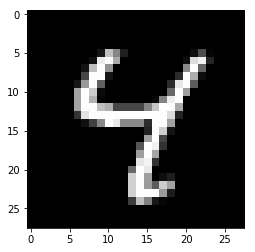

In [10]:
X3 = mnist.test.images[6]
img3 = X3.reshape([28, 28])
plt.imshow(img3, cmap='gray')
plt.show()

In [11]:
import pywt,cv2
imArray=np.float32(img3)/255;
cA2, (cH2, cV2, cD2)=pywt.wavedec2(imArray,'haar',level=1);
print(cD2.shape)
plt.imshow(cD2, cmap='gray')
X2=np.reshape(cA2,[1,-1])

X2=np.hstack((np.reshape(cA2,[1,-1]),np.reshape(cH2,[1,-1]) 
             ,np.reshape(cV2,[1,-1]),np.reshape(cD2,[1,-1])))
print(X2.shape)
plt.show()

ImportError: No module named pywt

In [12]:
X3.shape = [-1, 784]
y_batch = mnist.train.labels[0]
y_batch.shape = [-1, class_num]

X3_outputs = np.array(sess.run(outputs, feed_dict={
            _X: X3, y: y_batch, keep_prob: 1.0, batch_size: 1}))
print X3_outputs.shape
X3_outputs.shape = [28, hidden_size]
print X3_outputs.shape


(1, 28, 256)
(28, 256)


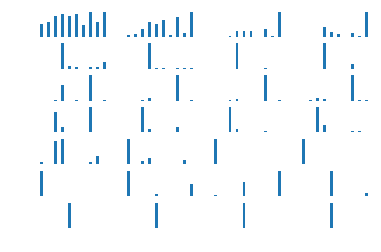

In [14]:
h_W = sess.run(W, feed_dict={
            _X:X3, y: y_batch, keep_prob: 1.0, batch_size: 1})
h_bias = sess.run(bias, feed_dict={
            _X:X3, y: y_batch, keep_prob: 1.0, batch_size: 1})
h_bias.shape = [-1, 10]

bar_index = range(class_num)
for i in xrange(X3_outputs.shape[0]):
    plt.subplot(7, 4, i+1)
    X3_h_shate = X3_outputs[i, :].reshape([-1, hidden_size])
    pro = sess.run(tf.nn.softmax(tf.matmul(X3_h_shate, h_W) + h_bias))
    plt.bar(bar_index, pro[0], width=0.4 , align='center')
    plt.axis('off')
plt.show()
